# Associative Networks

We have $m$ $n$-dimensional vectors $\vec{x}^{(1)}, \ldots,\vec{x}^{(m)}$ and $m$ $k$-dimensional vectors $\vec{y}^{(1)}, \ldots,\vec{y}^{(m)}$ represented as matrices $\mathbf{X}_{m \times n}$ and $\mathbf{Y}_{m \times k}$. We would like to associate pattern $\vec{x}^{(i)}$ with the pattern $\vec{y}^{(i)}$, for all $i=1,\ldots,m$ in the following way
$$\mathbf{Y} = \mathbf{X} \cdot \mathbf{W},$$ where $\mathbf{W}$ is a matrix with dimensions $n \times k$. This is mathematically not possible for arbitrary real-valued vectors.

**Additional asumptions:** the vectors $\vec{x}^{(1)}, \ldots,\vec{x}^{(m)}$ and $\vec{y}^{(1)}, \ldots,\vec{y}^{(m)}$ are **bipolar** and for mapping $\mathbf{X}$ into $\mathbf{Y}$ we use a single-layer neural network with the transfer function signum $$sgn(x) = \begin{cases} 
                1  & \text{ if } x\ge 0\\
                -1 & \text{ if } x < 0
            \end{cases}.$$ So we require $$\mathbf{Y} = sgn(\mathbf{X} \cdot \mathbf{W}).$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sgn(x):
    return 2 * (x >= 0) - 1

print(sgn(1))
print(sgn(np.array([-2, 0, 5])))

1
[-1  1  1]


We will experiment with 
* **autoassociative** networks for storing images of digits, and
* **heteroassociative** networks that associate pairs of images.

## Preparing Data
The files `zero.csv`, `one.csv`, ..., `nine.csv` contain matrices with a binary representation of pictures of the digits from 0 to 9.We can import these matrices. All matrices are of size $8\times 6$ and they contain numbers 0 and 1 only.

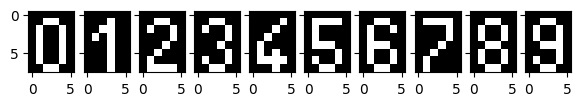

In [6]:
plt.figure(figsize=(7,2))
for i,d in enumerate(['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']):
    ar = np.genfromtxt('data/' + d + '.csv', delimiter=',', dtype=np.int8)
    plt.subplot(1, 10, i + 1)
    plt.imshow(ar,cmap='gray')

In order to obtain patterns as column vectors, we will reshape the arrays with all the digits and put them into one two-dimensional array.

[0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0
 1 0 0 1 0 0 0 1 1 0 0]


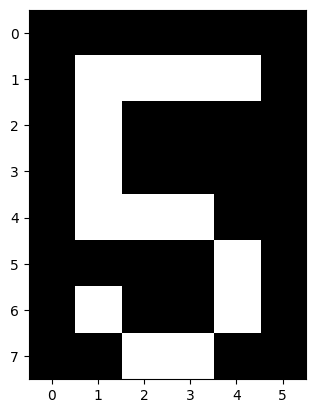

In [8]:
digits = np.empty(shape=(10,48), dtype=np.int8)
for i,d in enumerate(['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']):
    ar = np.genfromtxt('data/' + d+'.csv', delimiter=',', dtype=np.int8)
    digits[i] = ar.ravel()
    
plt.imshow(digits[5].reshape((8,6)), cmap='gray')
print(digits[5])

For learning associative networks, we need **bipolar** vectors:

In [9]:
digits = 2 * digits - 1
print(digits)

[[-1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1  1 -1
  -1  1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1  1  1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1  1 -1 -1 -1  1 -1  1 -1 -1
  -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1  1 -1
  -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1  1  1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1  1 -1
  -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1  1  1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1
  -1  1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1  1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1
  -1  1  1  1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1  1  1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1 -1
  -1  1  1  1 -1 -1 -1  1 -1 -1 

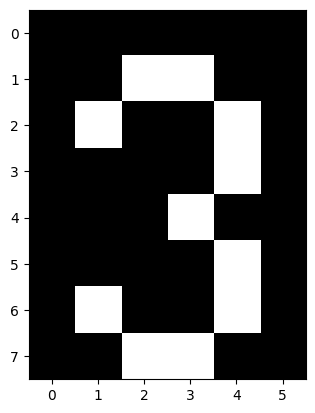

In [10]:
def show_digit(ar, shape=(8,6)):
    plt.imshow(ar.reshape(shape), cmap='gray')

show_digit(digits[3])

## Comparing Hebbian Learning and the method of pseudoinverse matrix

For $k=0,\dots,9$ compute the weight matrix of the **autoassociative** network representing the digits $0,…,k$ using
1. Hebbian learning and
2. learning using pseudoinverse matrix `np.linalg.pinv()`.

We will ask the following questions:
1. What is the maximal $k$ such that the network correctly recalls all digits $0,…,k$?
2. Will the number of correctly recalled images increase when we use **recurrent** networks with 1,2,3,4, or 5 iterations in the recall?
3. How well do networks recognize noisy pictures, i.e., pictures with Hamming distances 1,2,3,...,`n` from the learned patterns?

### Hebbian learning

Hebb rule:
> "any two cells or systems of cells that are repeatedly active at the same time will tend to become 'associated' so that activity in one facilitates activity in the other" [Hebb, D.O. (1949). The Organization of Behavior. New York: Wiley & Sons.]

Mathematically, for storing the pair of pattrens $\vec{x}$, $\vec{y}$, $$\mathbf{W} = \{ w_{ij}\}_{n \times k} = \{x_i y_j\}_{n \times k}.$$

For example, let us store the pair of patterns $x = (1, -1, -1, 1)$, $y = (-1,1,-1)$ in an associative network using Hebbian learning:
$$\mathbf{W} = \left[\begin{array}{rrr} -1 & 1 & -1 \\ 1 & -1 & 1\\ 1&-1&1\\-1&1&-1 \end{array}\right]$$

On input $(1, -1, -1, 1)$, the neurons have potential $\xi = \vec{x} \cdot \mathbf{W} = (-4, 4, -4)$ and after applying the transfer function we get $sgn(\xi) = (-1, 1, -1)$, which is the pattern $\vec{y}$.

Let us store digit 0 into an autoassociative network. 

In [11]:
W0 = digits[0].reshape(-1,1) @ digits[0].reshape(1,-1)
print(W0)

[[ 1  1  1 ... -1  1  1]
 [ 1  1  1 ... -1  1  1]
 [ 1  1  1 ... -1  1  1]
 ...
 [-1 -1 -1 ...  1 -1 -1]
 [ 1  1  1 ... -1  1  1]
 [ 1  1  1 ... -1  1  1]]


A simpler method is to use outer product of vectors

In [12]:
W0out = np.outer(digits[0],digits[0])
print(W0out)

[[ 1  1  1 ... -1  1  1]
 [ 1  1  1 ... -1  1  1]
 [ 1  1  1 ... -1  1  1]
 ...
 [-1 -1 -1 ...  1 -1 -1]
 [ 1  1  1 ... -1  1  1]
 [ 1  1  1 ... -1  1  1]]


Let us compute the output of the network when the input is the digit 0.

[-1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1  1 -1
 -1  1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1  1  1 -1 -1]


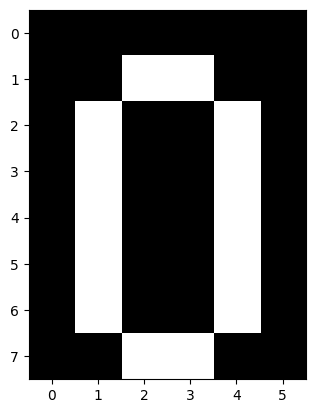

In [13]:
y = sgn(digits[0] @ W0)
print(y)
show_digit(y)

What will be the output of the network for image of digit 1 as its input.

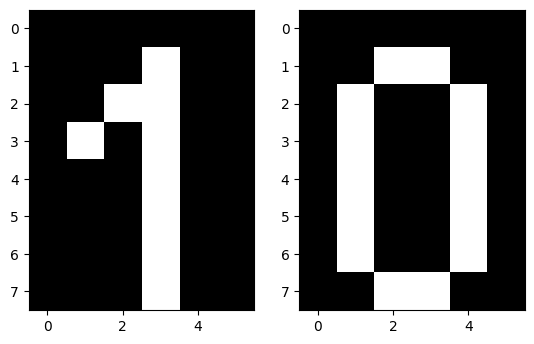

In [14]:
x = digits[1]
plt.subplot(1,2,1)
show_digit(x)

y = sgn(digits[1] @ W0)
plt.subplot(1,2,2)
show_digit(y)

Find maximal $k$, $1 \le k \le 10$ such that an autoassociative network trained on digits $0, \ldots, k-1$ correctly recalls all the stored digits. Illustrate with two-row plots. The first row contains the input images and the second one the output images. E.g.

<img alt="for inputs 0 and 1" src="pic12.png" size=200>

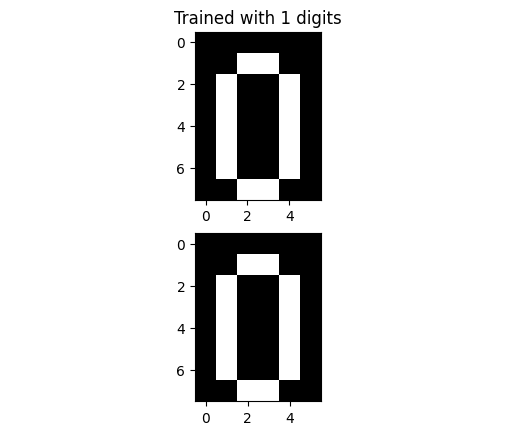

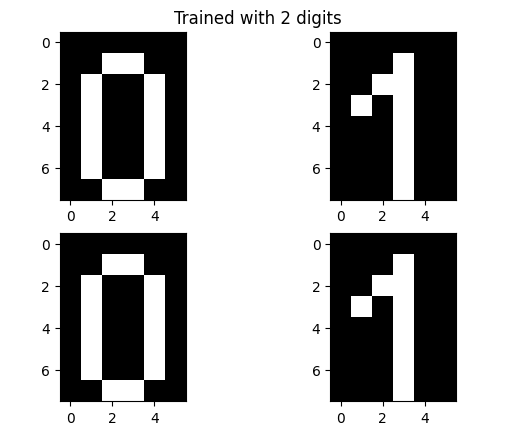

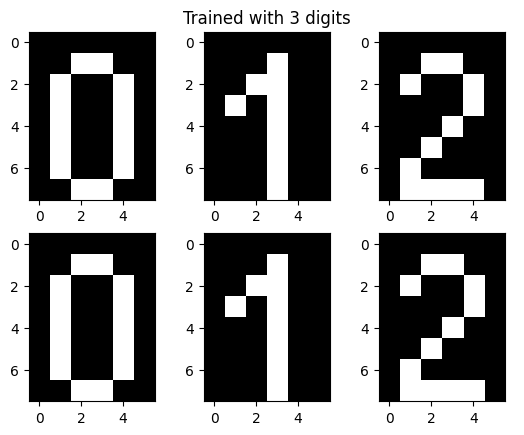

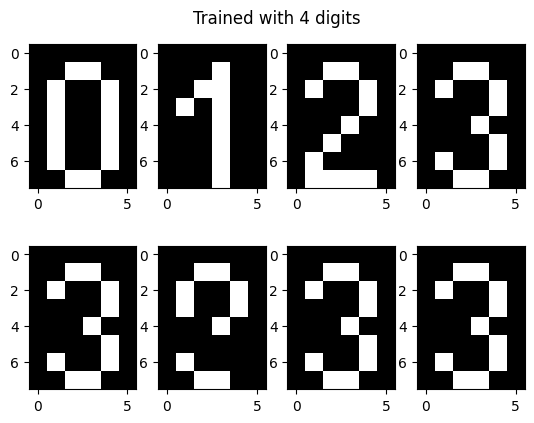

In [16]:
W0 = np.zeros((48,48))
for k in range(1,11):
    # store digits 0,...,k-1 into an autoassociative network with the weight matrix W

    # YOUR CODE HERE
    W0 = W0 + np.outer(digits[k-1],digits[k-1])

    # for all digits 0,...,k-1 as input, compute the output of the network
    X = digits[:k]
    y = sgn(X @ W0)

    # plot two rows of images: the input images and the recalled images

    fig, ax = plt.subplots()
    plt.title(f'Trained with {k} digits')
    ax.set_axis_off()
    # YOUR CODE HERE
    for i in range(k):
        plt.subplot(2, k, i+1)
        show_digit(X[i])

    for i in range(k):
        plt.subplot(2, k, k+i+1)
        show_digit(y[i])
        
    # stop if the output differs fro the input images
    # YOUR CODE HERE
    if not np.all(X == y):
        break

### Learning associative network using 'pseudoinversion'
 
Mathematically, for storing patterns $\mathbf{X}$ and $\mathbf{Y}$ in athe weight matrix $\mathbf{W}$, we would like to have
$$\mathbf{Y} = \mathbf{X}\cdot \mathbf{W}.$$
In case matrix $\mathbf{X}$ is square and non-singular, we can use its inverse
$$\mathbf{W} = \mathbf{X}^{-1} \cdot \mathbf{Y}.$$

In general, the matrix $\mathbf{X}$ is neither square, nor non-singular. For $\mathbf{X}$, however, there exists a (https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse)[pseudoinverse matrix] $\widetilde{\mathbf{X}}$.
> For $\mathbf{X} \in \mathrm{R}^{m \times n}$, a pseudoinverse of $\mathbf{X}$ is defined as a matrix $\widetilde{\mathbf{X}} \in \mathrm{R}^{n \times m}$ satisfying the following four Moore–Penrose conditions:
> 1. $\mathbf{X} \widetilde{\mathbf{X}}\mathbf{X} = \mathbf{X}$.
> 2. $\widetilde{\mathbf{X}} \mathbf{X} \widetilde{\mathbf{X}} = \widetilde{\mathbf{X}}$ - called weak inverse.
> 3. $(\mathbf{X} \widetilde{\mathbf{X}})^{\mathrm{T}} = \mathbf{X} \widetilde{\mathbf{X}}$.
> 4. $(\widetilde{\mathbf{X}} \mathbf{X})^{\mathrm{T}} = \widetilde{\mathbf{X}} \mathbf{X}$.

Additionally, if the columns of $\mathbf{X}$ are linearly independent, then $\mathbf{X}^{\mathrm{T}} \mathbf{X}$ is invertible and the pseudoinverse matrix can be computed as $$\widetilde{\mathbf{X}} = (\mathbf{X}^{\mathrm{T}} \mathbf{X})^{-1} \mathbf{X}^{\mathrm{T}}.$$

Using `numpy`, we can compute the pseudoinverse of matrix `X` as `np.linalg.pinv(X)`.

For example, let us store the pair of patterns $x = (1, -1, -1, 1)$, $y = (-1,1,-1)$ in an associative network using pseudoinverse matrix:
$$\mathbf{W} = \left[\begin{array}{rrr} -0.25 & 0.25 & -0.25 \\ 0.25 & -0.25 & 0.25\\ 0.25&-0.25&0.25\\-0.25&0.25&-0.25 \end{array}\right]$$

In [17]:
# using pseudoinverse matrix
W = np.linalg.pinv(np.array([[1, -1, -1, 1]])) @ np.array([[-1, 1, -1]])
print(W)

[[-0.25  0.25 -0.25]
 [ 0.25 -0.25  0.25]
 [ 0.25 -0.25  0.25]
 [-0.25  0.25 -0.25]]


On input $(1, -1, -1, 1)$, the neurons have potential $\xi = \vec{x} \cdot \mathbf{W} = (-1, 1, -1)$ and after applying the transfer function we get $sgn(\xi) = (-1, 1, -1)$, which is the pattern $\vec{y}$.

Let us store digit 0 into an autoassociative network using the pseudoinverse matrix method. 

In [18]:
W0pinv = np.linalg.pinv(digits[:1]) @ digits[:1]
print(W0pinv)

[[ 0.02083333  0.02083333  0.02083333 ... -0.02083333  0.02083333
   0.02083333]
 [ 0.02083333  0.02083333  0.02083333 ... -0.02083333  0.02083333
   0.02083333]
 [ 0.02083333  0.02083333  0.02083333 ... -0.02083333  0.02083333
   0.02083333]
 ...
 [-0.02083333 -0.02083333 -0.02083333 ...  0.02083333 -0.02083333
  -0.02083333]
 [ 0.02083333  0.02083333  0.02083333 ... -0.02083333  0.02083333
   0.02083333]
 [ 0.02083333  0.02083333  0.02083333 ... -0.02083333  0.02083333
   0.02083333]]


Let us compute the output of the network when the input is the digit 0.

[-1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1  1 -1
 -1  1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1  1  1 -1 -1]


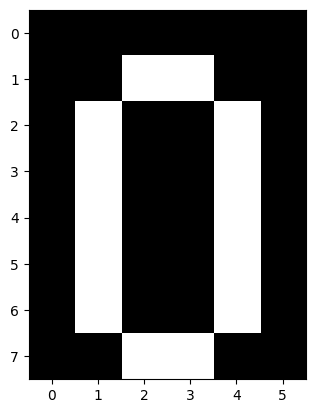

In [19]:
y = sgn(digits[0] @ W0pinv)
print(y)
show_digit(y)

What will be the output of the network for image of digit 1 as its input.

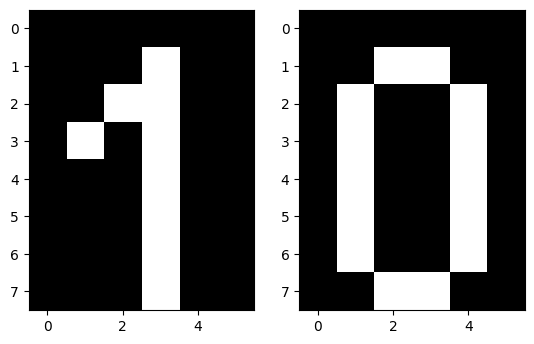

In [20]:
x = digits[1]
plt.subplot(1,2,1)
show_digit(x)

y = sgn(digits[1] @ W0pinv)
plt.subplot(1,2,2)
show_digit(y)

Find maximal $k$ $1 \le k \le 10$ such that an autoassociative network trained on digits $0, \ldots, k-1$ **using the pseudoinverse matrix method** correctly recalls all the stored digits. Illustrate with two-row plots. The first row contains the input images and the second one the output images. E.g.

<img alt="for inputs 0 and 1" src="pic12.png" size=200>

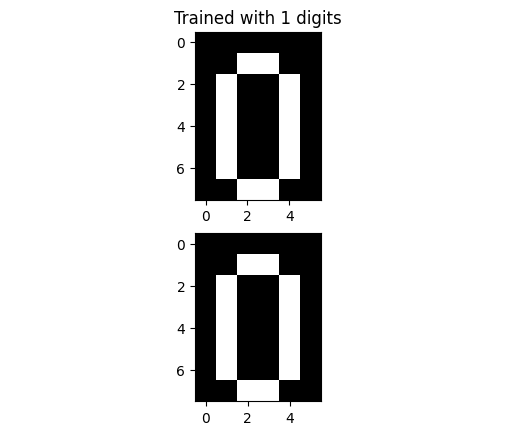

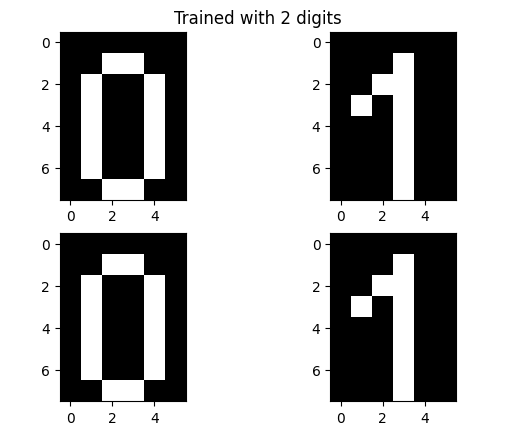

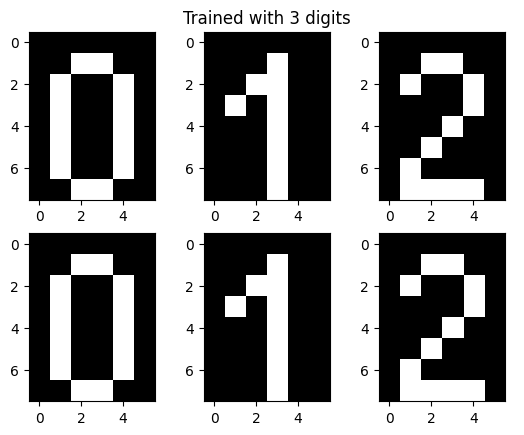

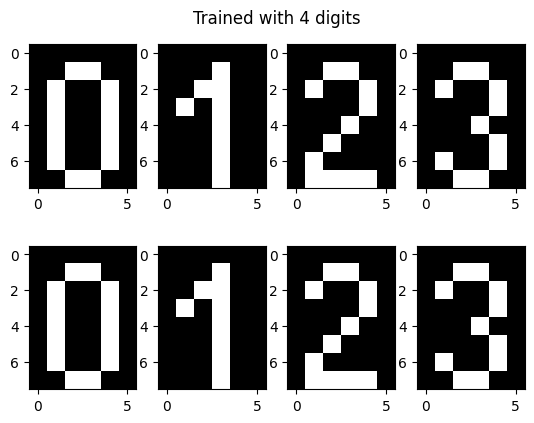

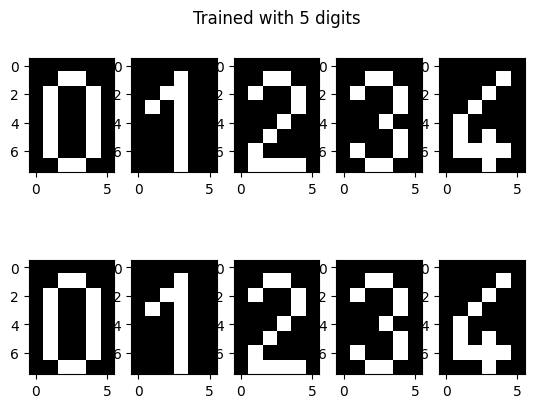

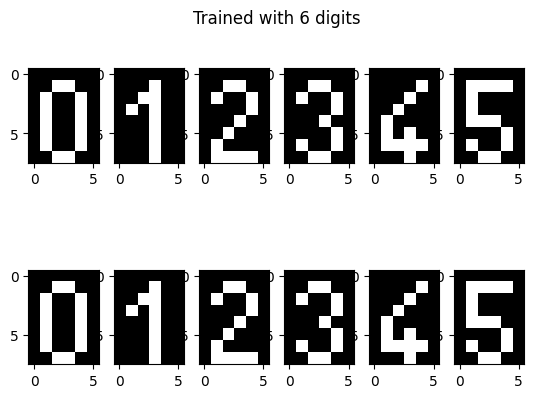

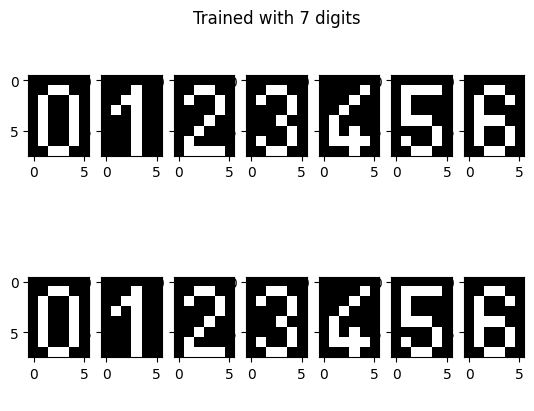

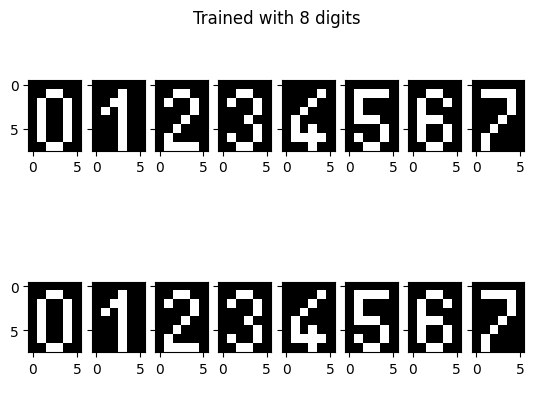

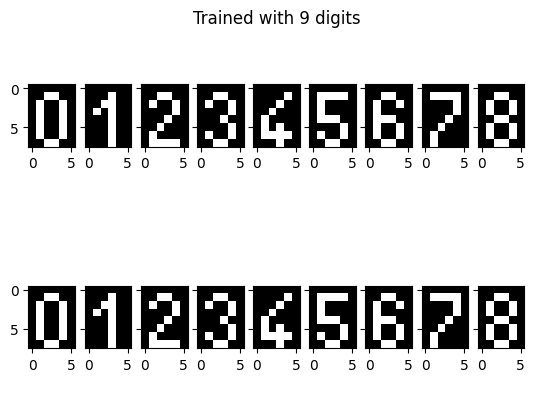

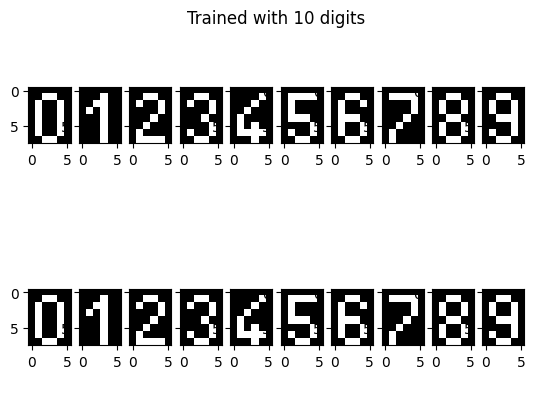

In [21]:

for k in range(1,11):
    # store digits 0,...,k-1 into an autoassociative network with the weight matrix W

    # YOUR CODE HERE
    W = np.linalg.pinv(digits[:k]) @ digits[:k]

    # for all digits 0,...,k-1 as input, compute the output of the network

    # YOUR CODE HERE
    y = sgn(digits[:k] @ W)

    # plot two rows of images: the input images and the recalled images

    fig, ax = plt.subplots()
    plt.title(f'Trained with {k} digits')
    ax.set_axis_off()
    # YOUR CODE HERE
    for i in range(k):
        plt.subplot(2, k, i+1)
        show_digit(digits[i])

    for i in range(k):
        plt.subplot(2, k, k+i+1)
        show_digit(y[i])

    # stop if the output differs fro the input images

    # YOUR CODE HERE
    if not np.all(digits[:k] == y):
        break

## Are the associative networks robust?

Test the robustness of associative networks trained by Hebbian learning and pseudoinverse matrix method, by adding a noise by randomly flipping $p= 1, 2, \ldots$ pixels.

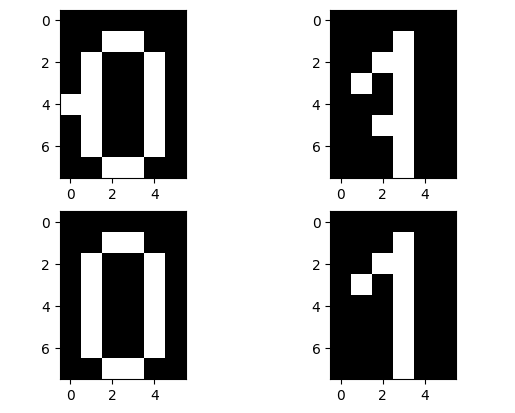

In [22]:
# adding one noise pixel
k = 2
X = digits[:k]
W = X.T @ X

Xnoise = X.copy()
Xnoise[0,24] *= -1
Xnoise[1,32] *= -1

Y = sgn(Xnoise @ W)

fig, ax = plt.subplots()
ax.set_axis_off()
for i in range(k):
    plt.subplot(2,k,i + 1)
    show_digit(Xnoise[i])
    plt.subplot(2,k,k + i + 1)
    show_digit(Y[i])

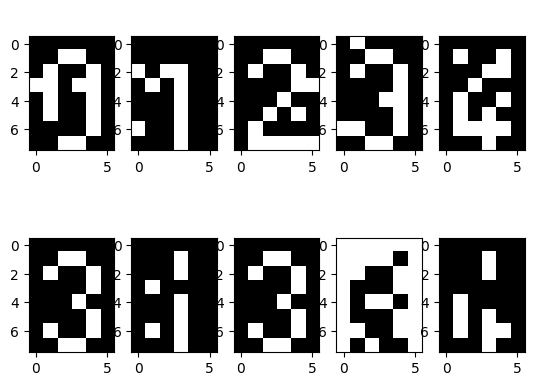

In [24]:
# robustness of networks trained using Hebb rule

#randomly flip 10% of the pixels for each number
k = 5
X = digits[:k]
W = X.T @ X

Xnoise = X.copy()
for i in range(k):
    for j in range(3):
        Xnoise[i,np.random.randint(48)] *= -1

Y = sgn(Xnoise @ W)

fig, ax = plt.subplots()
ax.set_axis_off()
for i in range(k):
    plt.subplot(2,k,i + 1)
    show_digit(Xnoise[i])
    plt.subplot(2,k,k + i + 1)
    show_digit(Y[i])



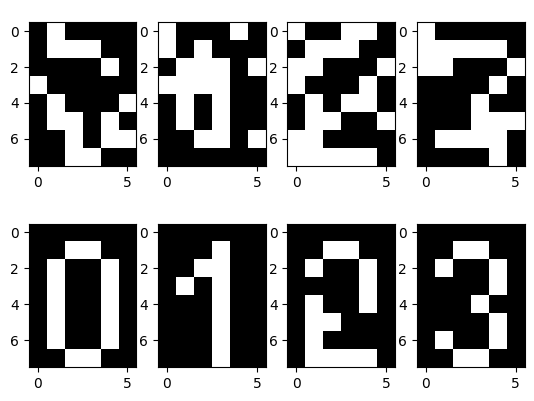

In [35]:
# robustness of networks trained using pseudoinverse matrix method

k = 4
X = digits[:k]
W = np.linalg.pinv(X) @ X

Xnoise = X.copy()
for i in range(k):
    for j in range(20):
        Xnoise[i,np.random.randint(48)] *= -1

Y = sgn(Xnoise @ W)

fig, ax = plt.subplots()
ax.set_axis_off()
for i in range(k):
    plt.subplot(2,k,i + 1)
    show_digit(Xnoise[i])
    plt.subplot(2,k,k + i + 1)
    show_digit(Y[i])

In [40]:
def robustivity(method  = 'inverse'):
    #this function aims to find the average number of pixels that can be flipped before the network fails for each number of pattern
    results = np.zeros(10)
    for k in range(1,11):
        X = digits[:k]
        if method == 'inverse':
            W = np.linalg.pinv(X) @ X
        else:
            W = X.T @ X
        runs_results = []
        for _ in range(20):
            for pixel_swapped in range (48):
                Xnoise = X.copy()
                for i in range(k):
                    for j in range(pixel_swapped):
                        Xnoise[i,np.random.randint(48)] *= -1
                Y = sgn(Xnoise @ W)
                if not np.all(X == Y):
                    break
            runs_results.append(pixel_swapped)
        results[k-1] = np.mean(runs_results)

    plt.plot(results)
    plt.xlabel('number of patterns')
    plt.ylabel('number of pixels that can be flipped')
                

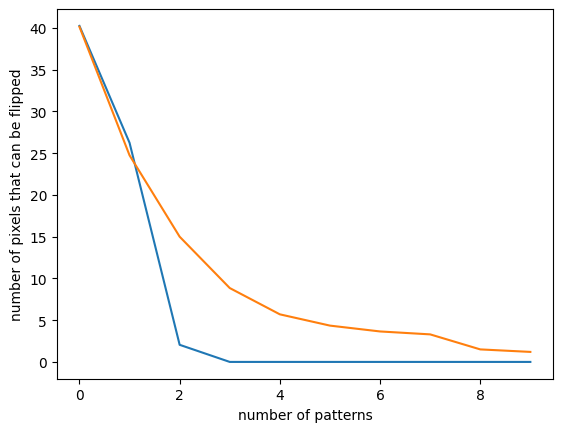

In [43]:
robustivity('hebb')
robustivity('inverse')

## Are recurrent associative networks more robust?

## BAM - Bidirectional Associative Memory

Learn a BAM to recognize pairs of digits $(x_0,y_0),\dots,(x_9,y_9)$, where $x_i$ is the vector representing the image of the digit $i$ and $y_i$ is the vector representing the image of the digit $9-i$. Then implement recall  for BAM networks
1. with synchronous update and
2. with  asynchronous update.

During iterative recall, print the energy of the network.

In [ ]:
digits_y = digits[::-1,:]
show_digit(digits_y[3])

In [ ]:
# using synchronous update


In [ ]:
# using asynchronous update


## Hopfield networks

Weights of a Hopfield network are initialized according to Hebbian rule:
$$W_{ij} = \sum_{p,i\ne j} x^p_ix^p_j, \quad W = \sum_{p}[(\vec{x}^p)^T \vec{x}^p-I],$$  where $I$ is the identity matrix. We suppose that the elements of the vectors are from the set  $\{-1,1\}$ and $\vec{x}^p$ is the $p$-th pattern as a **row vector**.

 

### Task:
Compute the weights of the Hopfield network learned to recognize the following patterns:

In [ ]:
B = np.array([[ 1,-1, 1,-1],
              [-1, 1, 1,-1],
              [-1,-1,-1,-1]
             ])

Which pattern will be recalled by the network for the input vector `[1,-1,-1,-1]` when we use
1. synchronous updates and
2. asynchronous updates?

Compute the energy of the network after each step of the recall.

In [ ]:
# synchronous updates


In [ ]:
# asynchronous update


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=42690e9b-4793-435d-9079-1c5e151d720a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>